In [1]:
import torch
from torchinfo import summary
from torchvision import transforms
from matplotlib import pyplot as plt

from networks_medium import Encoder, Decoder
from Autoencoders import ConformalAutoencoder
from data import CelebA

from vgg_perceptual_loss import VGGPerceptualLoss

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

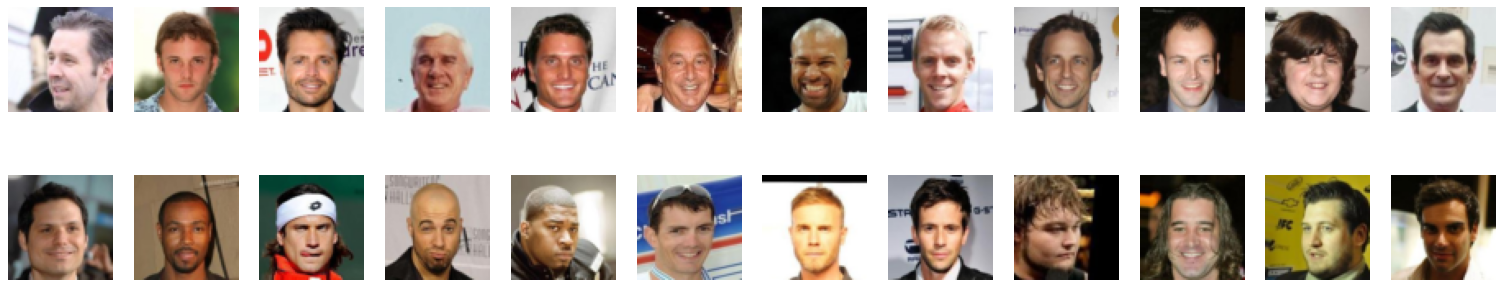

In [2]:
transform = [transforms.CenterCrop((178, 178)), transforms.Resize((64, 64))]
train_dataset = CelebA(root_dir="../", split="train", transform=transform, device=device, filter_categories=[(15, False), (20, True)])
val_dataset = CelebA(root_dir="../", split="val", transform=transform, device=device, filter_categories=[(15, False), (20, True)])

# show 2 rows of 12 images from train dataset
plt.figure(figsize=(24, 5), dpi=80)
for i in range(24):
    plt.subplot(2, 12, i + 1)
    plt.imshow(train_dataset[i][0].cpu().permute(1, 2, 0))
    plt.axis('off')
plt.show()

In [3]:
z_dim = 1024
in_ch = 3
out_ch = 3
base_ch = 32 #64
gap_ch = 3

encoder = Encoder(z_dim=z_dim, in_ch=in_ch, base_ch=base_ch, gap_ch=gap_ch)
decoder = Decoder(z_dim=z_dim, out_ch=out_ch, base_ch=base_ch, gap_ch=gap_ch)
encoder._build_fc_if_needed(16, 16)
decoder._build_fc_if_needed(16, 16)

In [4]:
from metrics import conformality_cosine_loss, conformality_trace_loss

lambda_conf = 0.01 #0.0023294465621657994
lambda_reg = 5.6e-4 #5.593799193170297e-07
lambda_aug = 0.05

conformal_autoencoder = ConformalAutoencoder(encoder, decoder,
                                             lambda_conf=lambda_conf, 
                                             lambda_reg=lambda_reg,
                                             reg_in_loss=True,
                                             lambda_aug=lambda_aug
                                             ).to(device)

conformal_autoencoder.conformality_loss = conformality_cosine_loss
conformal_autoencoder.reconstruction_loss = torch.nn.L1Loss()
perceptual_loss = VGGPerceptualLoss().to(device)
conformal_autoencoder.perceptual_loss = lambda x, y : 0.1 * perceptual_loss(x, y)

/home/hd/hd_hd/hd_dn249/.conda/envs/confAE/lib/python3.14/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/hd/hd_hd/hd_dn249/.conda/envs/confAE/lib/python3.14/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [5]:
bs = 256
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=bs, shuffle=True, num_workers=4)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=bs, shuffle=False, num_workers=4)

In [6]:
# If you want to load a model from checkpoint, uncomment the following lines:

# conformal_autoencoder.encoder._build_fc_if_needed(16,16)
# conformal_autoencoder.decoder._build_fc_if_needed(16,16)
# conformal_autoencoder.load_model_from_checkpoint("models/path.pth")

In [7]:
# if you want to load optimizer and scheduler state from checkpoint, uncomment the following lines (and include optimizer and scheduler in train_model call):

# optimizer = torch.optim.Adam(conformal_autoencoder.parameters(), lr=5e-4)
# scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.9)
# optimizer.load_state_dict(torch.load("models/celeba_autoencoder_v3_3_optimizer.pth"))
# scheduler.load_state_dict(torch.load("models/celeba_autoencoder_v3_3_scheduler.pth"))


In [11]:
epochs = 30
optimizer, scheduler = conformal_autoencoder.train_model(train_loader,
                                                         val_loader,
                                                         has_label=True,
                                                         epochs=epochs,
                                                         batch_size=bs,
                                                         learning_rate=1e-3,
                                                         val_every=10,
                                                         scheduler_kwargs={"step_size":20, "gamma":0.85}
                                                         )

OutOfMemoryError: CUDA out of memory. Tried to allocate 1.53 GiB. GPU 0 has a total capacity of 44.42 GiB of which 291.81 MiB is free. Including non-PyTorch memory, this process has 44.13 GiB memory in use. Of the allocated memory 42.84 GiB is allocated by PyTorch, and 984.22 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

In [ ]:
conformal_autoencoder.save_checkpoint("models/celeba_conformal_autoencoder_v3_5.pth")

In [24]:
torch.save(optimizer.state_dict(), "models/celeba_autoencoder_v3_3_optimizer.pth")
torch.save(scheduler.state_dict(), "models/celeba_autoencoder_v3_3_scheduler.pth")

In [ ]:
# conformal_autoencoder.load_model_from_checkpoint("models/celeba_conformal_autoencoder_v3_3.pth")

Model and custom variables loaded from models/celeba_conformal_autoencoder_v3_3.pth


ConformalAutoencoder(
  (encoder): Encoder(
    (conv0): ConvBNReLU(
      (block): Sequential(
        (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
      )
    )
    (down1): ConvBNReLU(
      (block): Sequential(
        (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
      )
    )
    (conv1): ConvBNReLU(
      (block): Sequential(
        (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
      )
    )
    (down2): ConvBNReLU(
      (block): Sequential(
        (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(2,

In [40]:
#get current learning rate
for param_group in optimizer.param_groups:
    current_lr = param_group['lr']
    break
print(f"Current learning rate: {current_lr}")

Current learning rate: 4.47169765519074e-06


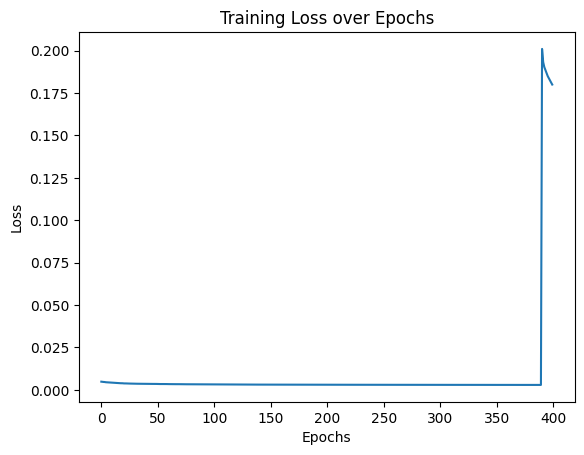

In [ ]:
plt.plot(conformal_autoencoder.metrics_list["reconstruction_loss"][:], label="Reconstruction Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training Loss over Epochs")
plt.show()

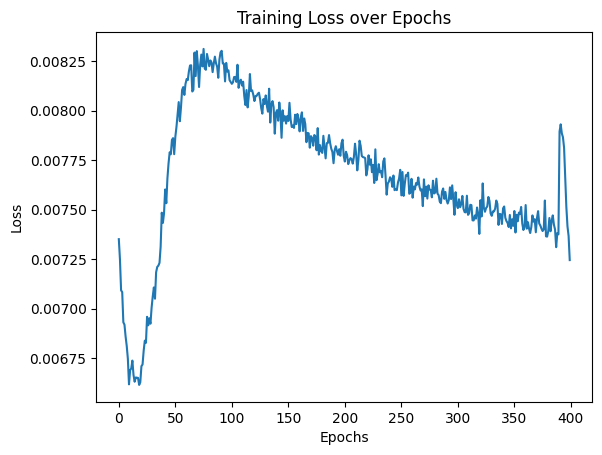

In [ ]:
plt.plot(conformal_autoencoder.metrics_list["conformal_loss"][:], label="Conformal Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training Loss over Epochs")
plt.show()

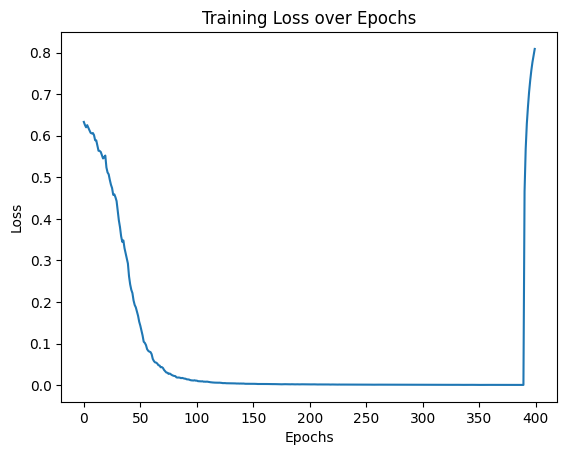

In [ ]:
plt.plot(conformal_autoencoder.metrics_list["regularization_loss"][:], label="Regularization Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training Loss over Epochs")
plt.show()

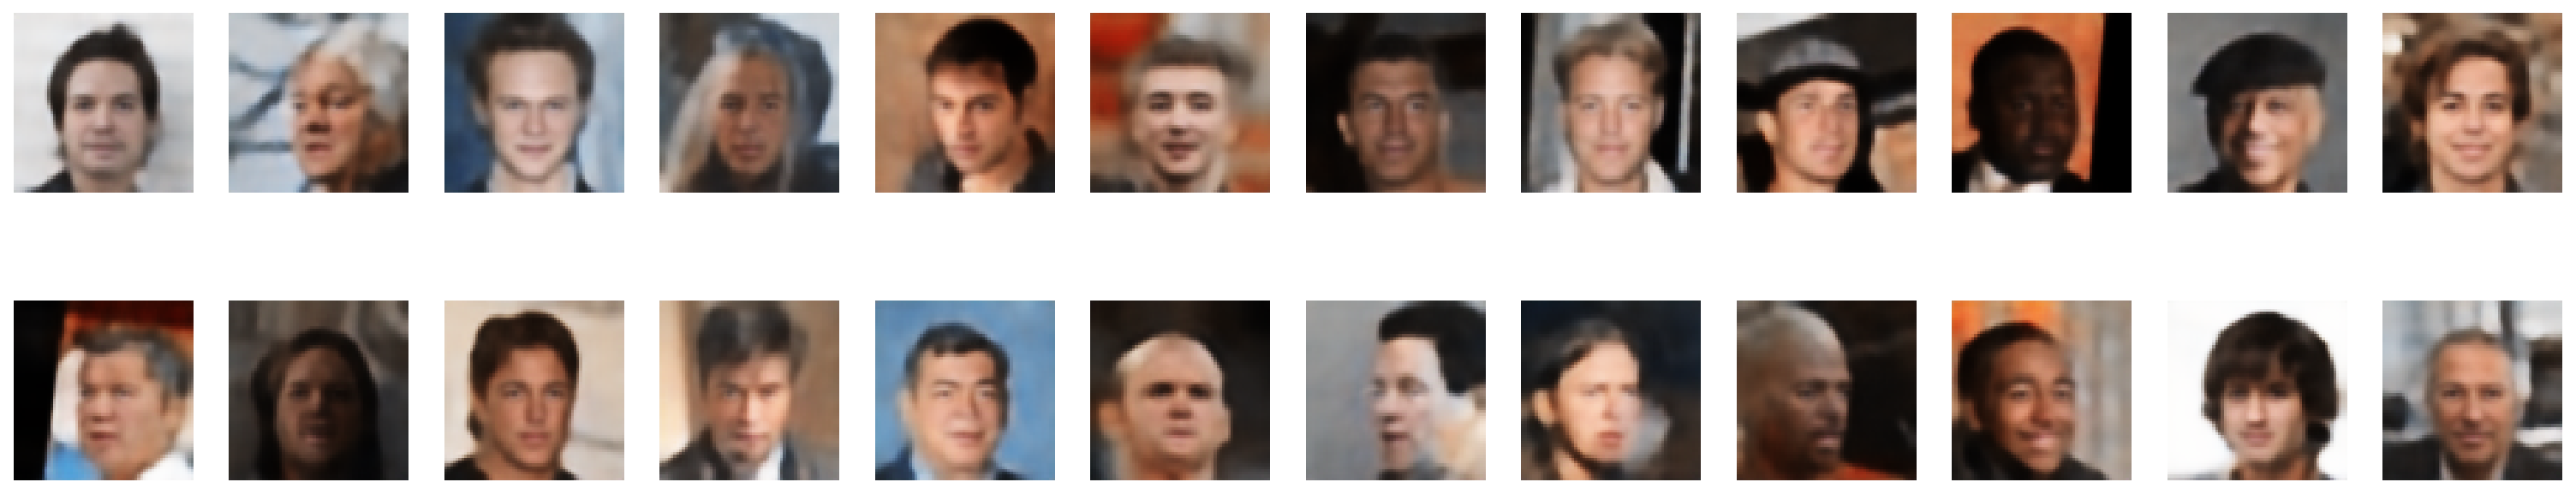

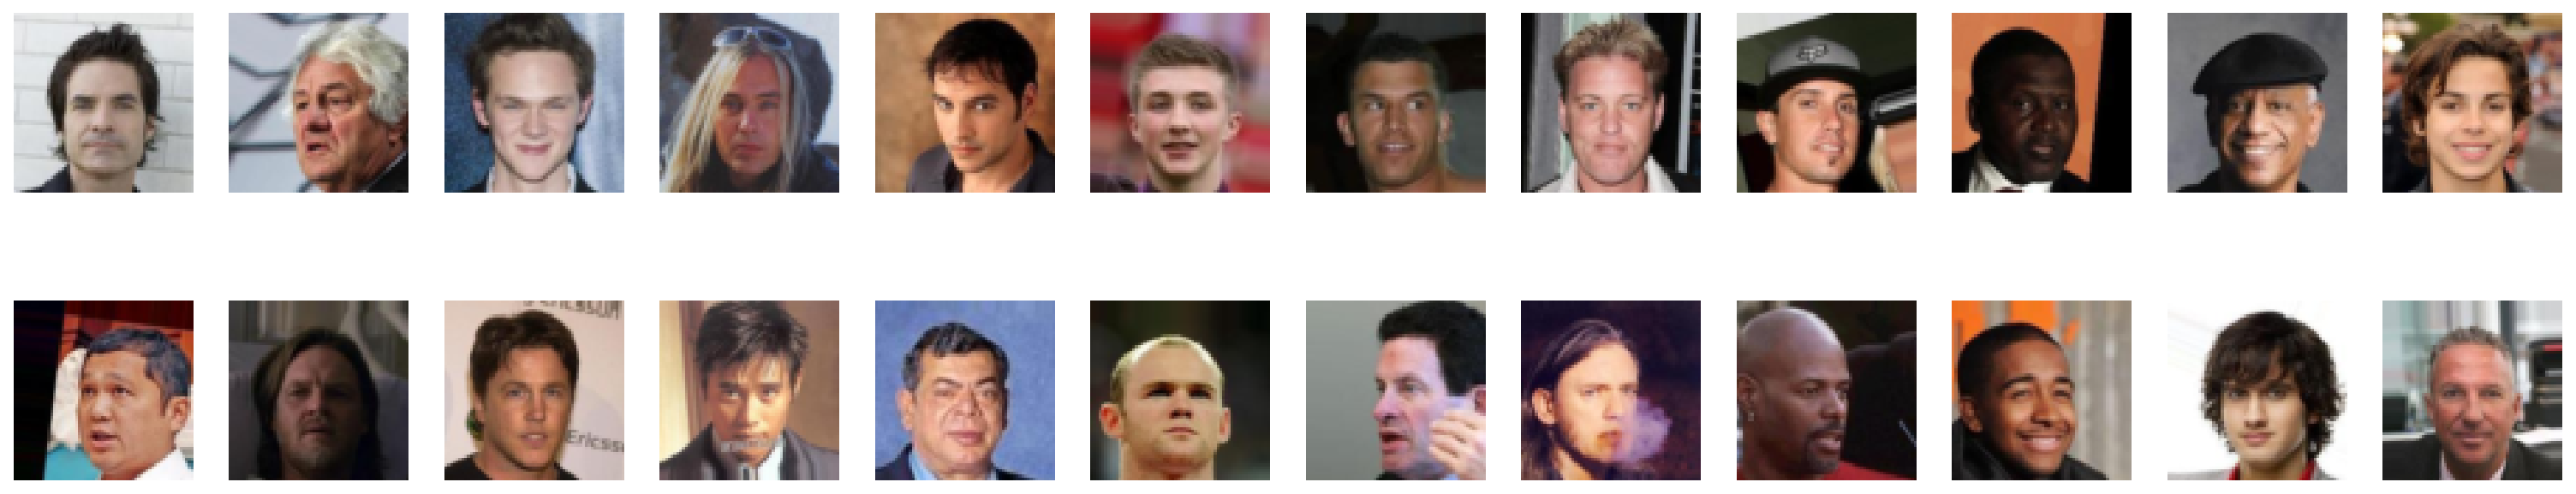

In [21]:
samples = conformal_autoencoder.forward(val_dataset.get_sample(24, seed=32)[0])
plt.figure(figsize=(24, 5), dpi=160)
for i in range(24):
    plt.subplot(2, 12, i + 1)
    plt.imshow(samples[i].permute(1, 2, 0).detach().cpu())
    plt.axis('off')
plt.show()
plt.figure(figsize=(24, 5), dpi=160)
for i in range(24):
    plt.subplot(2, 12, i + 1)
    plt.imshow(val_dataset.get_sample(24, seed=32)[0][i].permute(1, 2, 0).detach().cpu())
    plt.axis('off')
plt.show()